# Hands-on Start to MadGraph 

### 1st Workshop on New Light Physics and Photon-beam Experiments,  03/08/2021

### Yi-Ming Zhong (KICP, UChicago), ymzhong@kicp.uchicago.edu

### Convert LHE file to npy file

In [226]:
import os
import numpy as np

###########################################################
# convert LHE file to npy file using a script LHEtoPython
# npy_file_name: output npy file name
# lhe_file_name: input lhe file name
# incl_in=True/False: include incoming particles or not
# incl_mid=True/False: include intermediate particles or not 
# incl_out=True/False: include outgoing particles or not 
############################################################

def lhe2npy(npy_file_name, lhe_file_name="unweighted_events", incl_in=False, incl_mid=False, incl_out=True):
    incl_in_str = str(int(incl_in))
    incl_mid_str = str(int(incl_mid))
    incl_out_str = str(int(incl_out))
    output_file = "temp.dat"
    os.system("gunzip " + lhe_file_name + ".lhe.gz") 
    os.system("./LHEtoPython " + lhe_file_name + ".lhe " + incl_in_str + " " + incl_mid_str + " "+ incl_out_str + " >> " + output_file)
    with open(output_file, 'r') as f:
        text = f.read()
        for rep in (('{','['),('}',']')):text = text.replace(rep[0],rep[1])
        array = eval(text)
        particle_data = np.array(array)
        
    np.save(npy_file_name, particle_data)
    # check file size
    if os.path.getsize(npy_file_name + ".npy") > 0:
        print("success")
    else:
        print("fail")
    # remove the temp file
    os.system("rm " + output_file)

In [227]:
# convert the file
lhe2npy("babar_run_1", lhe_file_name="unweighted_events")

success


### Useful functions

In [228]:
# select particluar ID
def select_ID(event, ID_list):
    selected_event = []
    for ID_no in range(len(ID_list)):
            selected_event.append(event[event[:,0]==ID_list[ID_no]])
    return np.concatenate(selected_event)

# 3 momentum size
def p(p_arr):
    return np.linalg.norm(p_arr[[1,2,3]])
# transverse momentum
def pT(p_arr):
    return np.linalg.norm(p_arr[[1,2]])
# rapidity
def y(p_arr):
    return 0.5*np.log((p_arr[4]+p_arr[3])/(p_arr[4]-p_arr[3]))
# cos polar angle
def cos_theta(p_arr):
    return p_arr[3]/p(p_arr)
# pseudo-rapidity
def eta(p_arr):
    return 0.5*np.log((1+cos_theta(p_arr))/(1-cos_theta(p_arr)))
# particle mass
def m(p_arr):
    return np.sqrt(p_arr[4]**2 - p(p_arr)**2)
# azimuth angle
def phi(p_arr):
    if p_arr[1]>0:
        temp = np.arctan(p_arr[2]/p_arr[1])
    else:
        temp = np.sign(p_arr[2])*np.pi+np.arctan(p_arr[2]/p_arr[1])
    if temp <0:
        return temp + 2*np.pi
    else:
        return temp
# two particle invariant mass
def m12(p_arr_1, p_arr_2):
    p_12 = p_arr_1 + p_arr_2
    return m(p_12)
# delta R
def delta_R(p_arr_1, p_arr_2):
    delta_r_1 = np.sqrt((eta(p_arr_1)-eta(p_arr_2))**2+(phi(p_arr_1)-phi(p_arr_2))**2)
    delta_r_2 = np.sqrt((eta(p_arr_1)-eta(p_arr_2))**2+(phi(p_arr_1)-phi(p_arr_2)-2*np.pi)**2)
    delta_r_3 = np.sqrt((eta(p_arr_1)-eta(p_arr_2))**2+(phi(p_arr_1)-phi(p_arr_2)+2*np.pi)**2)
    return np.min([delta_r_1,delta_r_2,delta_r_3])
# vector angle
def angle(p_arr_1, p_arr_2):
    p1 = p_arr_1[[1,2,3]]/p(p_arr_1)
    p2 = p_arr_2[[1,2,3]]/p(p_arr_2)
    return np.arccos(np.dot(p1,p2))
# delta azimuth angle
def delta_phi(p_arr_1, p_arr_2):
    p1 = p_arr_1[[1,2]]/pT(p_arr_1)
    p2 = p_arr_2[[1,2]]/pT(p_arr_2)
    return np.arccos(np.dot(p1,p2))

# select particle ID then sort selected particle by p
def sort_p(event, ID_list):
    selected_event = select_ID(event, ID_list)
    p_list = []
    for i in range(len(selected_event)):
         p_list.append(p(test[i])) 
    return selected_event[np.flip(np.argsort(p_list))]

# missing momentum vector
def miss_vec(event):
    missing_ID = [12,-12,14,-14,16,-16]
    return np.sum(select_ID(event,missing_ID),axis=0)   

## Analysis ($e^+ e^- \to A' \gamma, A'\to e^+ e^-$ at BaBar)

In [229]:
# load run output
particle_data = np.load('babar_run_1.npy')

In [234]:
# define particle ID
eID = [11, -11]
aID = [22]
JetID = [21, 1, -1, 2, -2, 3, -3, 4, -4, 5, -5]
missID = [12,-12,14,-14,16,-16]
LeptonID = [11, -11, 13, -13, 15, -15]

In [305]:
cross_section = 0.1084 # pb
integrated_luminosity = 30 #/fb
total_event = cross_section*integrated_luminosity*1000
weight_factor =  total_event/len(particle_data)

In [306]:
pass_eta_cut = []
for i in range(len(particle_data)):
    photon = select_ID(particle_data[i], aID)
    if abs(eta(photon[0])) < 4.5:
        pass_eta_cut.append(particle_data[i])
pass_eta_cut =np.asarray(pass_eta_cut)   

In [307]:
print("efficiency to pass eta cut: " + str(len(pass_eta_cut)/len(particle_data)))

efficiency to pass eta cut: 0.8904


In [308]:
# compute photon momentum for all the events
photon_p_list = []
for i in range(len(pass_eta_cut)):
    photon = select_ID(pass_eta_cut[i], aID)
    photon_p_list.append(p(photon[0]))
photon_p_list = np.asarray(photon_p_list)

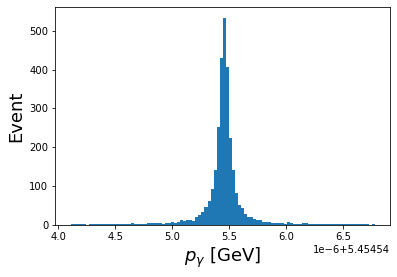

In [310]:
# make a 1D histogram of photon momentum
import matplotlib.pyplot as plt

weights = np.ones_like(photon_p_list)*weight_factor
#weights = np.ones_like(photon_p_list)/ len(photon_p_list)

fig, ax = plt.subplots(1,1)
ax.hist(photon_p_list,bins=100,weights=weights)
plt.xlabel(r'$p_\gamma$ [GeV]', fontsize=18)
plt.ylabel('Event',fontsize=18)
plt.show()

In [311]:
# compute photon momentum for all the events
m_ee_list = []
for i in range(len(pass_eta_cut)):
    epe = select_ID(pass_eta_cut[i], eID)
    m_ee_list.append(m12(epe[0], epe[1]))
m_ee_list = np.asarray(m_ee_list)

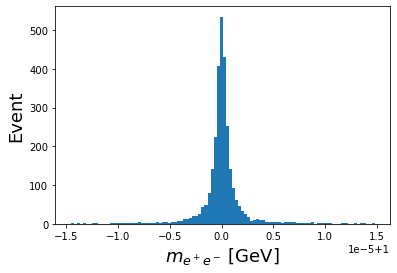

In [314]:
# make a 1D histogram of m_ee invariant mass
#weights = np.ones_like(m_ee_list) / len(m_ee_list)
weights = np.ones_like(m_ee_list)*weight_factor

fig, ax = plt.subplots(1,1)
ax.hist(m_ee_list,bins=100,weights=weights)
plt.xlabel(r'$m_{e^+ e^-}$ [GeV]', fontsize=18)
plt.ylabel('Event',fontsize=18)
plt.show()